# ***Replica Clinical State Binary Classification***

This notebook shows the process of classification section samples into binary clinical state (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [14]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [15]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 44000
# The MSI sample type for filtering
SAMPLE_TYPE = "r"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 0.5

### ***Reading MSI clinical state anotations***

Next, let's read the clinical state anotations for each MSI:

In [16]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all spectra's from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [17]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Keep sample file name of spectra
      file_names.append(msi_row.file_name)
      # Keep sample number of spectra
      sample_numbers.append(msi_row.sample_number)
      # Keep sample histology of spectra
      histologies.append(msi_row.histology)
      # Keep sample who grade of spectra
      who_grades.append(msi_row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)
        
# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:53<00:00,  7.21s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [18]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

In [19]:
mzs, _ =  parsers["HG 10-r"].getspectrum(0)
mzs_filter = (mzs >= 50) & (mzs < 600)

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [20]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra[mzs_filter], labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [21]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Leave one sample out classification:***

Next, let"s create a classification model for each leave one sample out option:

In [22]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_binary_accuracy",
      mode="max",
      save_best_only=True)

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              patience=5,
                                              min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(optimizer,
                               loss=losses.BinaryCrossentropy(),
                               metrics=["binary_accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=train_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator)
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator)

  # Clean model for next iteration
  classification_model = None

  # Separate training 
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
126/126 [==============================] - 42s 318ms/step - loss: 0.0927 - binary_accuracy: 0.9624 - val_loss: 0.6605 - val_binary_accuracy: 0.6165
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 2/100
126/126 [==============================] - 30s 237ms/step - loss: 0.0175 - binary_accuracy: 0.9937 - val_loss: 0.6047 - val_binary_accuracy: 0.9933
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 3/100
126/126 [==============================] - 30s 237ms/step - loss: 0.0097 - binary_accuracy: 0.9969 - val_loss: 0.4224 - val_binary_accuracy: 0.9483
Epoch 4/100
126/126 [==============================] - 30s 238ms/step - loss: 0.0082 - binary_accuracy: 0.9975 - val_loss: 0.1883 - val_binary_accuracy: 0.9726
Epoch 5/100
126/126 [==============================] - 30s 242ms/step - loss: 0.0067 - binary_accuracy: 0.9981 - val_loss: 0.0179 - val_

  5%|▍         | 1/22 [08:02<2:48:54, 482.58s/it]

##############################
Epoch 1/100
125/125 [==============================] - 33s 257ms/step - loss: 0.1557 - binary_accuracy: 0.9338 - val_loss: 0.6782 - val_binary_accuracy: 0.5530
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 2/100
125/125 [==============================] - 30s 239ms/step - loss: 0.0233 - binary_accuracy: 0.9924 - val_loss: 0.6739 - val_binary_accuracy: 0.4617
Epoch 3/100
125/125 [==============================] - 31s 245ms/step - loss: 0.0155 - binary_accuracy: 0.9954 - val_loss: 0.5897 - val_binary_accuracy: 0.5443
Epoch 4/100
125/125 [==============================] - 30s 242ms/step - loss: 0.0106 - binary_accuracy: 0.9966 - val_loss: 0.1273 - val_binary_accuracy: 0.9862
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 5/100
125/125 [==============================] - 31s 245ms/step - loss: 0.0078 - binary_accuracy: 0

  9%|▉         | 2/22 [16:22<2:44:11, 492.56s/it]

##############################
Epoch 1/100
132/132 [==============================] - 33s 241ms/step - loss: 0.1601 - binary_accuracy: 0.9321 - val_loss: 0.6838 - val_binary_accuracy: 0.4421
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 2/100
132/132 [==============================] - 32s 244ms/step - loss: 0.0264 - binary_accuracy: 0.9920 - val_loss: 0.8178 - val_binary_accuracy: 0.4290
Epoch 3/100
132/132 [==============================] - 32s 242ms/step - loss: 0.0146 - binary_accuracy: 0.9950 - val_loss: 0.8168 - val_binary_accuracy: 0.4371
Epoch 4/100
132/132 [==============================] - 32s 241ms/step - loss: 0.0093 - binary_accuracy: 0.9971 - val_loss: 0.1997 - val_binary_accuracy: 0.9432
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 5/100
132/132 [==============================] - 32s 242ms/step - loss: 0.0068 - binary_accuracy: 0

 14%|█▎        | 3/22 [24:10<2:32:27, 481.47s/it]

##############################
Epoch 1/100
131/131 [==============================] - 34s 252ms/step - loss: 0.1744 - binary_accuracy: 0.9272 - val_loss: 0.6946 - val_binary_accuracy: 0.4336
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 2/100
131/131 [==============================] - 33s 247ms/step - loss: 0.0218 - binary_accuracy: 0.9927 - val_loss: 0.9774 - val_binary_accuracy: 0.4336
Epoch 3/100
131/131 [==============================] - 33s 251ms/step - loss: 0.0147 - binary_accuracy: 0.9949 - val_loss: 0.9865 - val_binary_accuracy: 0.4352
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 4/100
131/131 [==============================] - 33s 248ms/step - loss: 0.0142 - binary_accuracy: 0.9950 - val_loss: 0.3913 - val_binary_accuracy: 0.8268
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\

 18%|█▊        | 4/22 [32:06<2:23:46, 479.26s/it]

##############################
Epoch 1/100
130/130 [==============================] - 33s 250ms/step - loss: 0.1745 - binary_accuracy: 0.9244 - val_loss: 0.6673 - val_binary_accuracy: 0.5646
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 2/100
130/130 [==============================] - 33s 250ms/step - loss: 0.0214 - binary_accuracy: 0.9931 - val_loss: 0.6436 - val_binary_accuracy: 0.4799
Epoch 3/100
130/130 [==============================] - 32s 249ms/step - loss: 0.0152 - binary_accuracy: 0.9947 - val_loss: 0.6132 - val_binary_accuracy: 0.4911
Epoch 4/100
130/130 [==============================] - 33s 255ms/step - loss: 0.0108 - binary_accuracy: 0.9963 - val_loss: 0.2922 - val_binary_accuracy: 0.8772
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 5/100
130/130 [==============================] - 34s 259ms/step - loss: 0.0087 - binary_accuracy: 0

 23%|██▎       | 5/22 [38:49<2:07:58, 451.68s/it]

##############################
Epoch 1/100
131/131 [==============================] - 34s 256ms/step - loss: 0.1748 - binary_accuracy: 0.9272 - val_loss: 0.6747 - val_binary_accuracy: 0.5665
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 2/100
131/131 [==============================] - 33s 250ms/step - loss: 0.0222 - binary_accuracy: 0.9929 - val_loss: 0.6474 - val_binary_accuracy: 0.4518
Epoch 3/100
131/131 [==============================] - 33s 254ms/step - loss: 0.0145 - binary_accuracy: 0.9955 - val_loss: 0.5609 - val_binary_accuracy: 0.5070
Epoch 4/100
131/131 [==============================] - 33s 252ms/step - loss: 0.0120 - binary_accuracy: 0.9960 - val_loss: 0.1117 - val_binary_accuracy: 0.9734
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 5/100
131/131 [==============================] - 33s 251ms/step - loss: 0.0080 - binary_accuracy: 0

 27%|██▋       | 6/22 [47:59<2:09:24, 485.27s/it]

##############################
Epoch 1/100
126/126 [==============================] - 35s 271ms/step - loss: 0.1512 - binary_accuracy: 0.9372 - val_loss: 0.6810 - val_binary_accuracy: 0.9608
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 2/100
126/126 [==============================] - 34s 269ms/step - loss: 0.0227 - binary_accuracy: 0.9930 - val_loss: 0.7378 - val_binary_accuracy: 0.4516
Epoch 3/100
126/126 [==============================] - 35s 274ms/step - loss: 0.0109 - binary_accuracy: 0.9965 - val_loss: 0.8292 - val_binary_accuracy: 0.4518
Epoch 4/100
126/126 [==============================] - 35s 277ms/step - loss: 0.0082 - binary_accuracy: 0.9973 - val_loss: 0.1973 - val_binary_accuracy: 0.9416
Epoch 5/100
126/126 [==============================] - 35s 280ms/step - loss: 0.0076 - binary_accuracy: 0.9976 - val_loss: 0.0581 - val_binary_accuracy: 0.9778
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/

 32%|███▏      | 7/22 [55:05<1:56:26, 465.77s/it]

##############################
Epoch 1/100
130/130 [==============================] - 35s 262ms/step - loss: 0.1731 - binary_accuracy: 0.9273 - val_loss: 0.6709 - val_binary_accuracy: 0.5625
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 2/100
130/130 [==============================] - 32s 248ms/step - loss: 0.0236 - binary_accuracy: 0.9921 - val_loss: 0.6664 - val_binary_accuracy: 0.4456
Epoch 3/100
130/130 [==============================] - 36s 279ms/step - loss: 0.0150 - binary_accuracy: 0.9953 - val_loss: 0.5309 - val_binary_accuracy: 0.6074
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 4/100
130/130 [==============================] - 36s 278ms/step - loss: 0.0115 - binary_accuracy: 0.9963 - val_loss: 0.2663 - val_binary_accuracy: 0.9007
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\

 36%|███▋      | 8/22 [1:06:01<2:02:49, 526.36s/it]

##############################
Epoch 1/100
128/128 [==============================] - 35s 269ms/step - loss: 0.1752 - binary_accuracy: 0.9271 - val_loss: 0.6770 - val_binary_accuracy: 0.5623
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 2/100
128/128 [==============================] - 36s 281ms/step - loss: 0.0219 - binary_accuracy: 0.9928 - val_loss: 0.6984 - val_binary_accuracy: 0.4447
Epoch 3/100
128/128 [==============================] - 36s 279ms/step - loss: 0.0165 - binary_accuracy: 0.9942 - val_loss: 0.6497 - val_binary_accuracy: 0.4954
Epoch 4/100
128/128 [==============================] - 36s 284ms/step - loss: 0.0126 - binary_accuracy: 0.9962 - val_loss: 0.3564 - val_binary_accuracy: 0.8453
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 5/100
128/128 [==============================] - 34s 261ms/step - loss: 0.0078 - binary_accuracy:

 41%|████      | 9/22 [1:15:43<1:57:49, 543.77s/it]

##############################
Epoch 1/100
132/132 [==============================] - 38s 280ms/step - loss: 0.1661 - binary_accuracy: 0.9290 - val_loss: 0.6706 - val_binary_accuracy: 0.5690
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 2/100
132/132 [==============================] - 35s 266ms/step - loss: 0.0214 - binary_accuracy: 0.9923 - val_loss: 0.5981 - val_binary_accuracy: 0.7624
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 3/100
132/132 [==============================] - 35s 260ms/step - loss: 0.0136 - binary_accuracy: 0.9957 - val_loss: 0.4709 - val_binary_accuracy: 0.8005
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 4/100
132/132 [==============================] - 36s 277ms/step - loss: 0.0090 - binary_accuracy: 0.9969 - val_loss: 0.1605 - val_binary_accurac

 45%|████▌     | 10/22 [1:26:26<1:54:54, 574.52s/it]

##############################
Epoch 1/100
131/131 [==============================] - 36s 271ms/step - loss: 0.1609 - binary_accuracy: 0.9315 - val_loss: 0.7011 - val_binary_accuracy: 0.4342
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 2/100
131/131 [==============================] - 35s 267ms/step - loss: 0.0218 - binary_accuracy: 0.9933 - val_loss: 1.0255 - val_binary_accuracy: 0.4342
Epoch 3/100
131/131 [==============================] - 37s 284ms/step - loss: 0.0160 - binary_accuracy: 0.9945 - val_loss: 0.9061 - val_binary_accuracy: 0.4386
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 4/100
131/131 [==============================] - 36s 271ms/step - loss: 0.0109 - binary_accuracy: 0.9961 - val_loss: 0.2444 - val_binary_accuracy: 0.9289
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 50%|█████     | 11/22 [1:34:37<1:40:36, 548.81s/it]

##############################
Epoch 1/100
126/126 [==============================] - 35s 275ms/step - loss: 0.1724 - binary_accuracy: 0.9274 - val_loss: 0.6754 - val_binary_accuracy: 0.8741
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 2/100
126/126 [==============================] - 35s 274ms/step - loss: 0.0227 - binary_accuracy: 0.9918 - val_loss: 0.7058 - val_binary_accuracy: 0.4527
Epoch 3/100
126/126 [==============================] - 35s 279ms/step - loss: 0.0148 - binary_accuracy: 0.9950 - val_loss: 0.7110 - val_binary_accuracy: 0.4744
Epoch 4/100
126/126 [==============================] - 34s 270ms/step - loss: 0.0124 - binary_accuracy: 0.9957 - val_loss: 0.2075 - val_binary_accuracy: 0.9395
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 5/100
126/126 [==============================] - 35s 278ms/step - loss: 0.0079 - binary_accuracy:

 55%|█████▍    | 12/22 [1:43:38<1:31:05, 546.56s/it]

##############################
Epoch 1/100
127/127 [==============================] - 37s 286ms/step - loss: 0.1710 - binary_accuracy: 0.9285 - val_loss: 0.6731 - val_binary_accuracy: 0.5522
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 2/100
127/127 [==============================] - 35s 274ms/step - loss: 0.0228 - binary_accuracy: 0.9924 - val_loss: 0.6276 - val_binary_accuracy: 0.6144
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 3/100
127/127 [==============================] - 33s 264ms/step - loss: 0.0146 - binary_accuracy: 0.9952 - val_loss: 0.6609 - val_binary_accuracy: 0.4805
Epoch 4/100
127/127 [==============================] - 35s 278ms/step - loss: 0.0150 - binary_accuracy: 0.9949 - val_loss: 0.3113 - val_binary_accuracy: 0.8655
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 59%|█████▉    | 13/22 [1:51:38<1:18:56, 526.30s/it]

##############################
Epoch 1/100
130/130 [==============================] - 36s 269ms/step - loss: 0.1635 - binary_accuracy: 0.9315 - val_loss: 0.6799 - val_binary_accuracy: 0.5829
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 2/100
130/130 [==============================] - 36s 279ms/step - loss: 0.0197 - binary_accuracy: 0.9935 - val_loss: 0.8323 - val_binary_accuracy: 0.4356
Epoch 3/100
130/130 [==============================] - 37s 285ms/step - loss: 0.0109 - binary_accuracy: 0.9964 - val_loss: 0.7614 - val_binary_accuracy: 0.4481
Epoch 4/100
130/130 [==============================] - 37s 288ms/step - loss: 0.0129 - binary_accuracy: 0.9963 - val_loss: 0.3759 - val_binary_accuracy: 0.8850
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 5/100
130/130 [==============================] - 35s 267ms/step - loss: 0.0102 - binary_accuracy:

 64%|██████▎   | 14/22 [2:07:10<1:26:31, 648.88s/it]

##############################
Epoch 1/100
130/130 [==============================] - 36s 268ms/step - loss: 0.1555 - binary_accuracy: 0.9332 - val_loss: 0.6583 - val_binary_accuracy: 0.5990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 2/100
130/130 [==============================] - 37s 285ms/step - loss: 0.0209 - binary_accuracy: 0.9929 - val_loss: 0.6014 - val_binary_accuracy: 0.6038
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 3/100
130/130 [==============================] - 37s 281ms/step - loss: 0.0142 - binary_accuracy: 0.9953 - val_loss: 0.5598 - val_binary_accuracy: 0.4897
Epoch 4/100
130/130 [==============================] - 37s 282ms/step - loss: 0.0110 - binary_accuracy: 0.9966 - val_loss: 0.1710 - val_binary_accuracy: 0.9499
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 68%|██████▊   | 15/22 [2:15:19<1:10:05, 600.80s/it]

##############################
Epoch 1/100
120/120 [==============================] - 32s 262ms/step - loss: 0.1956 - binary_accuracy: 0.9171 - val_loss: 0.6536 - val_binary_accuracy: 0.6473
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 2/100
120/120 [==============================] - 33s 272ms/step - loss: 0.0243 - binary_accuracy: 0.9920 - val_loss: 0.6103 - val_binary_accuracy: 0.6473
Epoch 3/100
120/120 [==============================] - 34s 285ms/step - loss: 0.0140 - binary_accuracy: 0.9956 - val_loss: 0.5368 - val_binary_accuracy: 0.8681
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 4/100
120/120 [==============================] - 33s 276ms/step - loss: 0.0122 - binary_accuracy: 0.9960 - val_loss: 0.3385 - val_binary_accuracy: 0.8816
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 73%|███████▎  | 16/22 [2:25:04<59:36, 596.06s/it]  

##############################
Epoch 1/100
130/130 [==============================] - 38s 289ms/step - loss: 0.1773 - binary_accuracy: 0.9252 - val_loss: 0.6808 - val_binary_accuracy: 0.5961
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 2/100
130/130 [==============================] - 37s 281ms/step - loss: 0.0217 - binary_accuracy: 0.9926 - val_loss: 0.5958 - val_binary_accuracy: 0.6769
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 3/100
130/130 [==============================] - 37s 280ms/step - loss: 0.0165 - binary_accuracy: 0.9946 - val_loss: 0.4347 - val_binary_accuracy: 0.9149
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 4/100
130/130 [==============================] - 38s 289ms/step - loss: 0.0122 - binary_accuracy: 0.9965 - val_loss: 0.1363 - val_binary_accurac

 77%|███████▋  | 17/22 [2:32:43<46:13, 554.75s/it]

##############################
Epoch 1/100
128/128 [==============================] - 37s 280ms/step - loss: 0.1582 - binary_accuracy: 0.9324 - val_loss: 0.7123 - val_binary_accuracy: 0.6065
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 2/100
128/128 [==============================] - 34s 267ms/step - loss: 0.0206 - binary_accuracy: 0.9930 - val_loss: 0.6063 - val_binary_accuracy: 0.6098
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 3/100
128/128 [==============================] - 34s 262ms/step - loss: 0.0129 - binary_accuracy: 0.9958 - val_loss: 0.3868 - val_binary_accuracy: 0.9697
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 4/100
128/128 [==============================] - 34s 264ms/step - loss: 0.0099 - binary_accuracy: 0.9967 - val_loss: 0.1429 - val_binary_accurac

 82%|████████▏ | 18/22 [2:42:26<37:33, 563.33s/it]

##############################
Epoch 1/100
128/128 [==============================] - 36s 277ms/step - loss: 0.1124 - binary_accuracy: 0.9557 - val_loss: 0.6929 - val_binary_accuracy: 0.5548
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 2/100
128/128 [==============================] - 34s 270ms/step - loss: 0.0197 - binary_accuracy: 0.9932 - val_loss: 0.6117 - val_binary_accuracy: 0.5599
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 3/100
128/128 [==============================] - 36s 278ms/step - loss: 0.0112 - binary_accuracy: 0.9967 - val_loss: 0.4101 - val_binary_accuracy: 0.9868
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 4/100
128/128 [==============================] - 35s 278ms/step - loss: 0.0082 - binary_accuracy: 0.9973 - val_loss: 0.1451 - val_binary_accurac

 86%|████████▋ | 19/22 [2:50:30<26:58, 539.54s/it]

##############################
Epoch 1/100
130/130 [==============================] - 36s 270ms/step - loss: 0.1631 - binary_accuracy: 0.9300 - val_loss: 0.6567 - val_binary_accuracy: 0.5992
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 2/100
130/130 [==============================] - 35s 264ms/step - loss: 0.0219 - binary_accuracy: 0.9926 - val_loss: 0.6256 - val_binary_accuracy: 0.7660
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 3/100
130/130 [==============================] - 37s 283ms/step - loss: 0.0125 - binary_accuracy: 0.9958 - val_loss: 0.5524 - val_binary_accuracy: 0.6495
Epoch 4/100
130/130 [==============================] - 36s 273ms/step - loss: 0.0090 - binary_accuracy: 0.9967 - val_loss: 0.2016 - val_binary_accuracy: 0.9272
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 91%|█████████ | 20/22 [3:04:47<21:09, 634.63s/it]

##############################
Epoch 1/100
128/128 [==============================] - 38s 287ms/step - loss: 0.1714 - binary_accuracy: 0.9265 - val_loss: 0.6685 - val_binary_accuracy: 0.6207
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 2/100
128/128 [==============================] - 35s 270ms/step - loss: 0.0234 - binary_accuracy: 0.9927 - val_loss: 1.0283 - val_binary_accuracy: 0.3943
Epoch 3/100
128/128 [==============================] - 37s 287ms/step - loss: 0.0148 - binary_accuracy: 0.9951 - val_loss: 0.9841 - val_binary_accuracy: 0.3953
Epoch 4/100
128/128 [==============================] - 36s 282ms/step - loss: 0.0124 - binary_accuracy: 0.9962 - val_loss: 0.3460 - val_binary_accuracy: 0.8819
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 5/100
128/128 [==============================] - 35s 271ms/step - loss: 0.0101 - binary_accuracy:

 95%|█████████▌| 21/22 [3:14:36<10:21, 621.15s/it]

##############################
Epoch 1/100
127/127 [==============================] - 35s 267ms/step - loss: 0.1687 - binary_accuracy: 0.9280 - val_loss: 0.6717 - val_binary_accuracy: 0.6138
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 2/100
127/127 [==============================] - 36s 283ms/step - loss: 0.0247 - binary_accuracy: 0.9920 - val_loss: 0.6223 - val_binary_accuracy: 0.6177
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 3/100
127/127 [==============================] - 37s 289ms/step - loss: 0.0147 - binary_accuracy: 0.9957 - val_loss: 0.4639 - val_binary_accuracy: 0.9258
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 4/100
127/127 [==============================] - 33s 256ms/step - loss: 0.0110 - binary_accuracy: 0.9964 - val_loss: 0.1612 - val_binary_accurac

100%|██████████| 22/22 [3:23:49<00:00, 555.86s/it]

##############################


In [23]:
train_metrics

{2: [4.1064108700084034e-06, 1.0],
 3: [0.00020351943385321647, 0.9999372363090515],
 4: [1.0602453585306648e-05, 1.0],
 5: [0.0001395932340528816, 0.9999400973320007],
 6: [0.0003889923682436347, 0.9999699592590332],
 7: [1.2770095963787753e-05, 1.0],
 8: [0.0003163287474308163, 0.9999688267707825],
 9: [0.00010160935926251113, 1.0],
 10: [3.137812382192351e-05, 1.0],
 11: [3.3826556773419725e-06, 1.0],
 12: [0.0006040689186193049, 0.999970018863678],
 13: [7.140624074963853e-05, 1.0],
 14: [0.0008269674144685268, 0.9999690651893616],
 15: [0.0002048288006335497, 0.9999698996543884],
 16: [7.284782623173669e-05, 0.9999697804450989],
 18: [1.9293373043183237e-05, 1.0],
 19: [4.2369920265628025e-05, 1.0],
 20: [1.0330957593396306e-05, 1.0],
 21: [1.1713409548974596e-05, 1.0],
 23: [2.709199407036067e-06, 1.0],
 25: [0.0004577284271363169, 0.999969482421875],
 29: [6.336627393466188e-06, 1.0]}

In [24]:
validation_metrics

{2: [0.0038038501515984535, 0.9995025992393494],
 3: [0.0005244326312094927, 1.0],
 4: [0.0019126826664432883, 0.9996445775032043],
 5: [0.0020159040577709675, 0.9997605085372925],
 6: [0.0031718104146420956, 0.9992784857749939],
 7: [0.0014615639811381698, 0.9998802542686462],
 8: [0.0010172310285270214, 0.9997506141662598],
 9: [0.002929879818111658, 0.9995166659355164],
 10: [0.0018453585216775537, 0.9995090365409851],
 11: [0.0017338244942948222, 0.9995238780975342],
 12: [0.0070742093957960606, 0.9988009333610535],
 13: [0.002320694737136364, 0.999500036239624],
 14: [0.0027906789910048246, 0.9995052218437195],
 15: [0.0018050041981041431, 0.999639093875885],
 16: [0.004198967944830656, 0.9995167255401611],
 18: [0.017190078273415565, 0.9990861415863037],
 19: [0.008764402940869331, 0.9986774325370789],
 20: [0.006358616519719362, 0.9993883967399597],
 21: [0.00702308677136898, 0.9988935589790344],
 23: [0.002706157974898815, 0.9993956685066223],
 25: [0.004770543891936541, 0.9995

### ***Leave one sample out classification evaluation - tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [25]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:39<00:00,  4.54s/it]


Next, let's get some statistics about each left out sample predictions:

In [26]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9986814857,1.0000000000,0.9999951124,0.9999889135,0.0000437271,0,1
1,3,0.0000035465,0.9999568462,0.1257909387,0.3134973645,0.3552904427,1,0
2,4,0.0000227273,1.0000000000,0.9964930415,0.8556169868,0.2824991345,1,1
3,5,0.9662109613,1.0000000000,1.0000000000,0.9999136329,0.0013570923,1,1
4,6,0.9790852070,0.9998924732,0.9989560246,0.9986345172,0.0012074629,1,1
5,7,0.9891809821,0.9999945164,0.9999309778,0.9997436404,0.0007016785,1,1
6,8,0.0000028777,0.9997478127,0.0020331212,0.0645413175,0.1787725836,1,0
7,9,0.9999877214,1.0000000000,0.9999985695,0.9999983907,0.0000011677,1,1
8,10,0.9999657869,1.0000000000,0.9999998808,0.9999995232,0.0000014582,1,1
9,11,0.9740490913,0.9999995232,0.9999510050,0.9997953176,0.0012079581,1,1


Next, let's evaluate the classification performance:

In [27]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.773
Balanced  Accuracy: 0.768
Precision: 0.846
Recall: 0.786
F1 score: 0.815


Next, let's plot the roc curve:

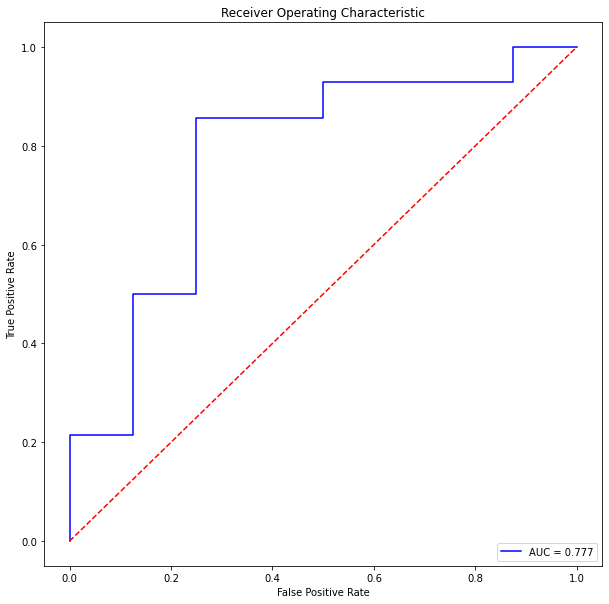

In [28]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

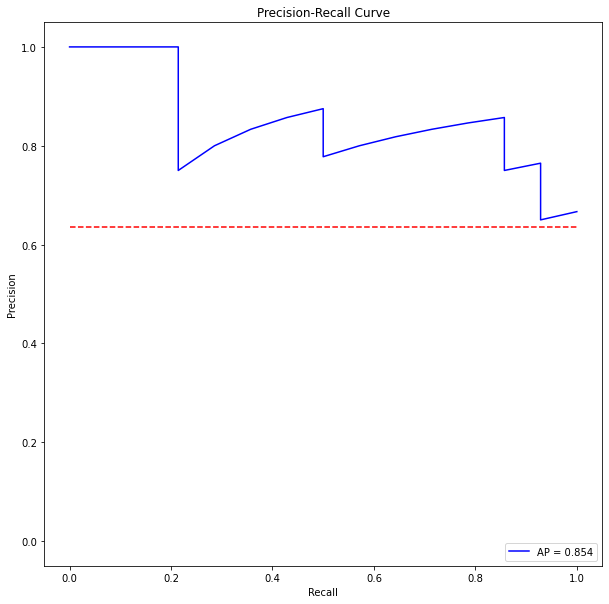

In [29]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

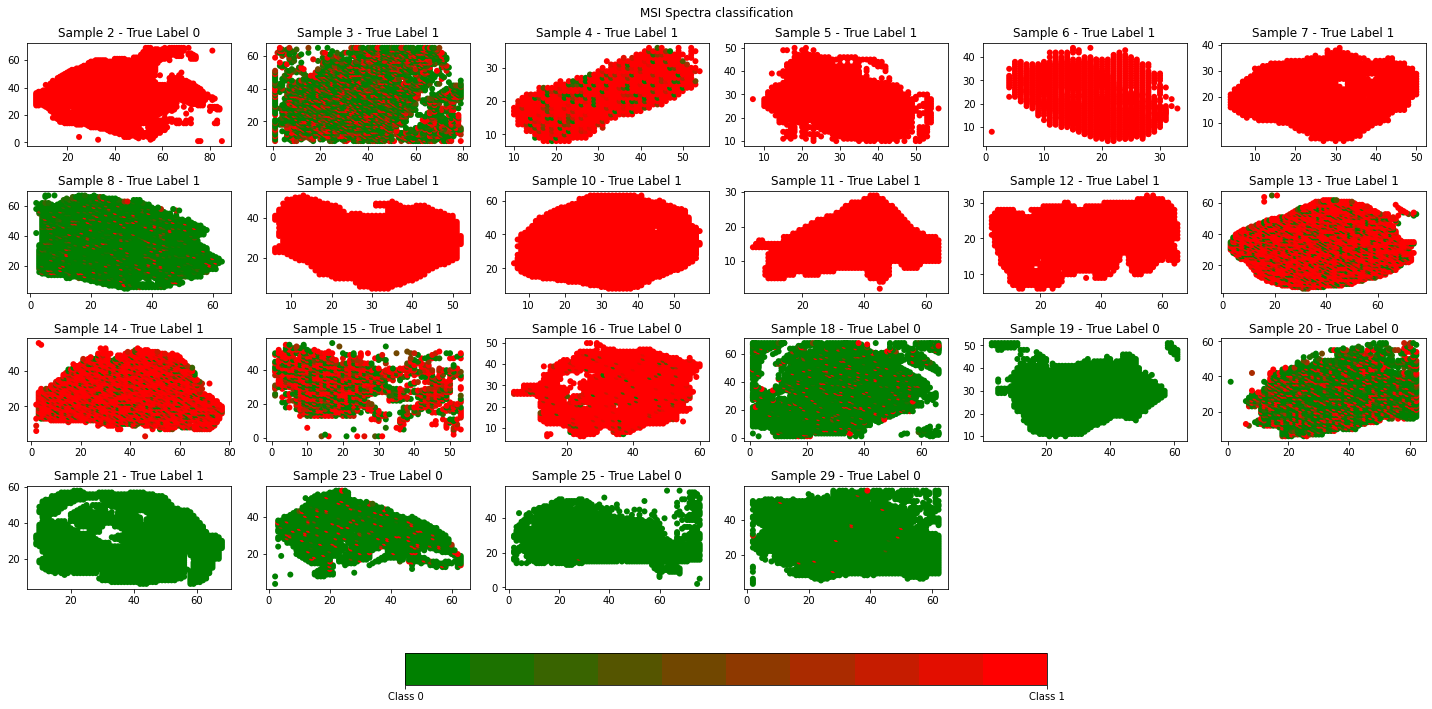

In [30]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Leave one sample out classification evaluation - non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [31]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:47<00:00,  4.87s/it]


Next, let's get some statistics about each left out sample predictions:

In [32]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.0000000000,1.0000000000,0.9999957085,0.9787826538,0.1400580704,0,1
1,3,0.0000000179,0.9999617338,0.0939009711,0.3375894725,0.3922295868,1,0
2,4,0.9907029867,1.0000000000,0.9999986887,0.9999769926,0.0002567621,1,1
3,5,0.0288805552,1.0000000000,0.9999870062,0.9951938391,0.0459767543,1,1
4,6,0.7704880238,0.9998169541,0.9971234202,0.9939807057,0.0110168522,1,1
5,7,0.8102337122,0.9999961853,0.9998406172,0.9981859922,0.0075971023,1,1
6,8,0.0000000000,0.9999998808,0.9862181544,0.7305088639,0.3993397057,1,1
7,9,0.9999897480,1.0000000000,0.9999992847,0.9999986291,0.0000017303,1,1
8,10,0.9998683929,1.0000000000,0.9999996424,0.9999983907,0.0000063041,1,1
9,11,0.4796245396,0.9999992847,0.9999434948,0.9990907311,0.0168346260,1,1


Next, let's evaluate the classification performance:

In [33]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.773
Balanced  Accuracy: 0.768
Precision: 0.846
Recall: 0.786
F1 score: 0.815


Next, let's plot the roc curve:

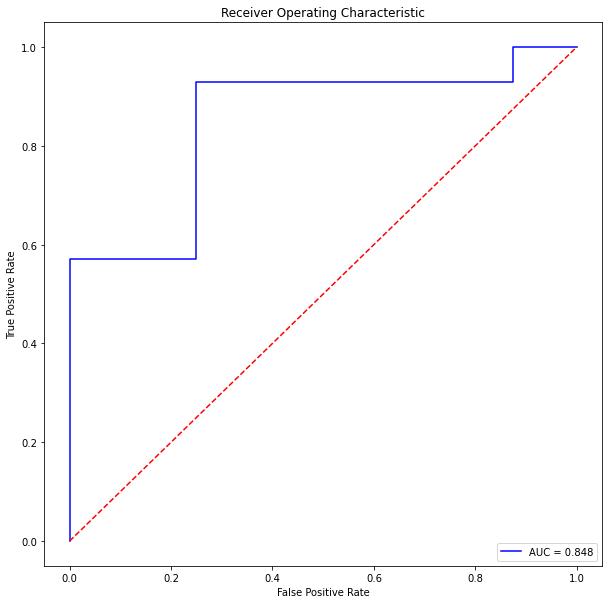

In [34]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

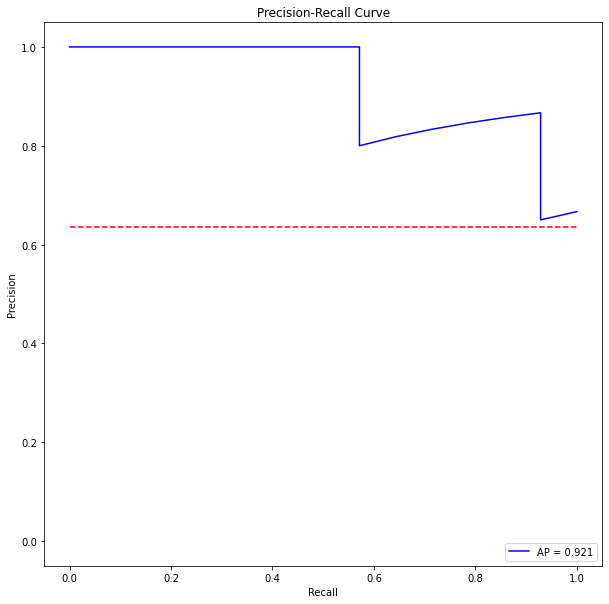

In [35]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

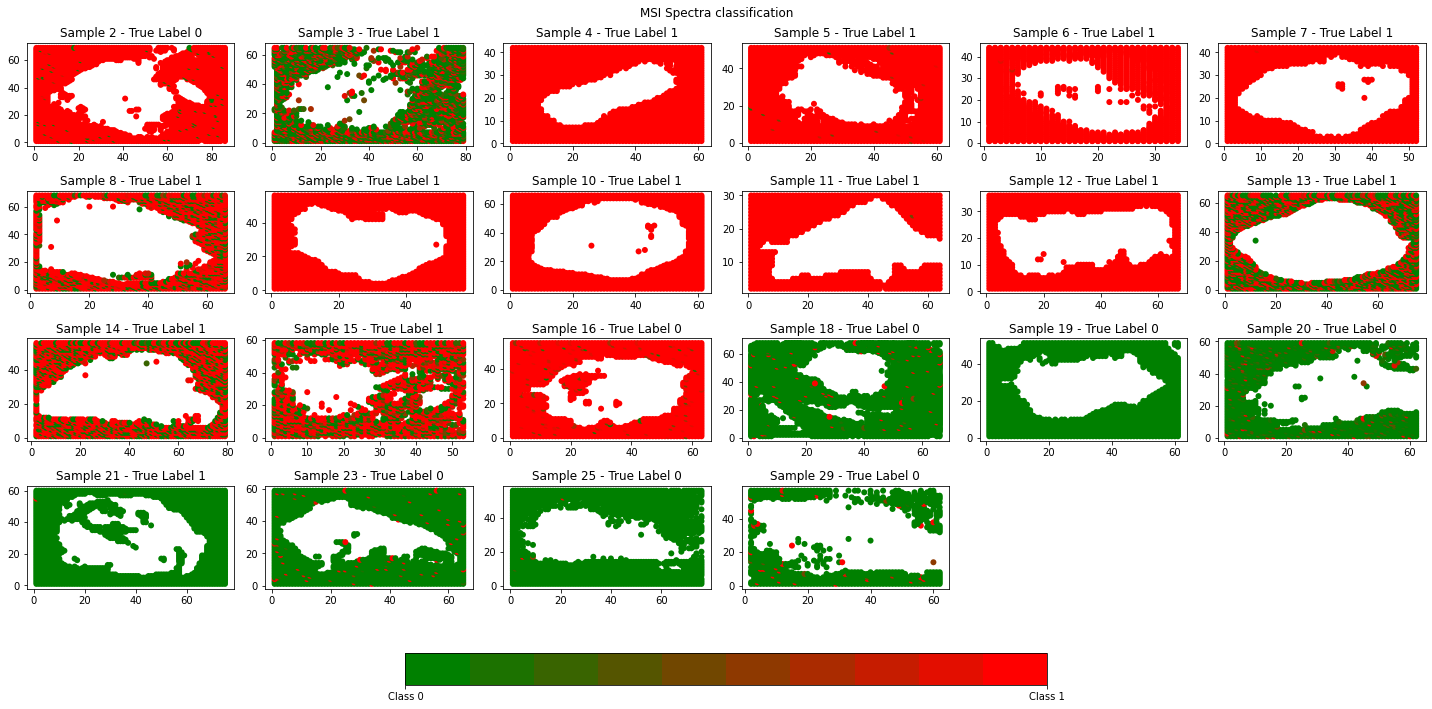

In [36]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [37]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()